In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import deep_fib

from common.models import resnet, deeplab
from common import metrics


# Hyperparameters

In [3]:
log_dir = "./trained/deep_fib"

horizon = 1024
stride = 512

batch_size = 32

num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-2

n_masks = 25
loss_type = "mse"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.MINMAX)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.MINMAX)


Loading: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


In [6]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size,
    shuffle=False,
)


# Model

In [7]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
        num_features=data.NUM_FEATURES,
    ),
    backbone_channels=[256, 2048],
    out_feats=data.NUM_FEATURES,
).float()

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine = deep_fib.DeepFIBEngine(
    model=model,
    device=device,
    optimizer=optim,
    lr_scheduler=lr_sched,
    masks=deep_fib.get_masks(horizon, n_masks).float(),
    loss_type=loss_type,
)


# Training

In [8]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss = 0.009 - test_loss = 0.009 - test_cost=188.725 - test_threshold=0.112 - lr = 1.00e-03


Epoch 1 - train_loss = 0.007 - test_loss = 0.008 - test_cost=183.161 - test_threshold=0.101 - lr = 9.76e-04


Epoch 2 - train_loss = 0.006 - test_loss = 0.008 - test_cost=191.518 - test_threshold=0.108 - lr = 9.05e-04


Epoch 3 - train_loss = 0.006 - test_loss = 0.007 - test_cost=185.873 - test_threshold=0.102 - lr = 7.94e-04


Epoch 4 - train_loss = 0.006 - test_loss = 0.007 - test_cost=181.544 - test_threshold=0.101 - lr = 6.55e-04


Epoch 5 - train_loss = 0.005 - test_loss = 0.007 - test_cost=192.219 - test_threshold=0.102 - lr = 5.00e-04


Epoch 6 - train_loss = 0.005 - test_loss = 0.007 - test_cost=189.754 - test_threshold=0.097 - lr = 3.45e-04


Epoch 7 - train_loss = 0.005 - test_loss = 0.007 - test_cost=190.260 - test_threshold=0.097 - lr = 2.06e-04


Epoch 8 - train_loss = 0.005 - test_loss = 0.006 - test_cost=190.357 - test_threshold=0.097 - lr = 9.55e-05


Epoch 9 - train_loss = 0.005 - test_loss = 0.006 - test_cost=191.293 - test_threshold=0.095 - lr = 2.45e-05


# Evaluating

In [9]:
# Cost model
cmodel = metrics.default_cmodel()


In [10]:
all_errors, all_labels = get_predictions(engine.predict, test_loader)


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


In [11]:
cmodel.fit(all_errors, all_labels).optimize()


(0.0852842162363231, 204.55951)

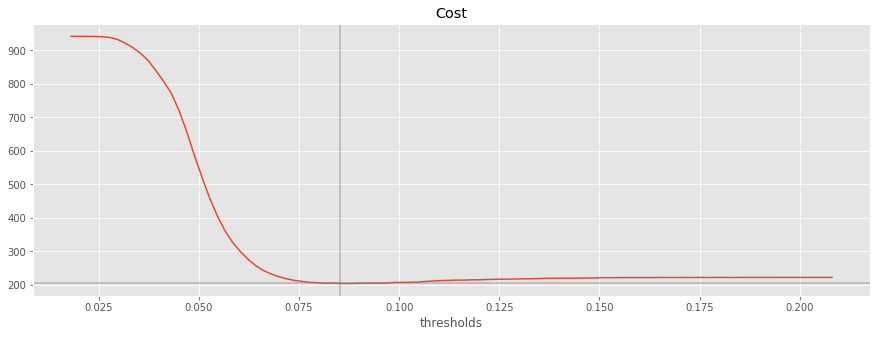

In [12]:
metrics.plot_cost(cmodel)


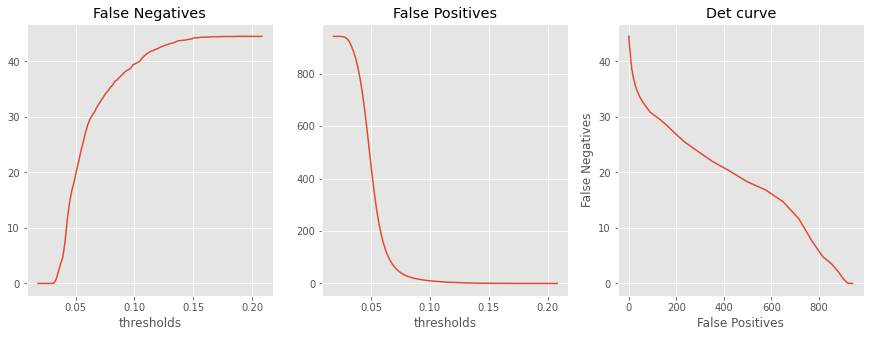

In [13]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


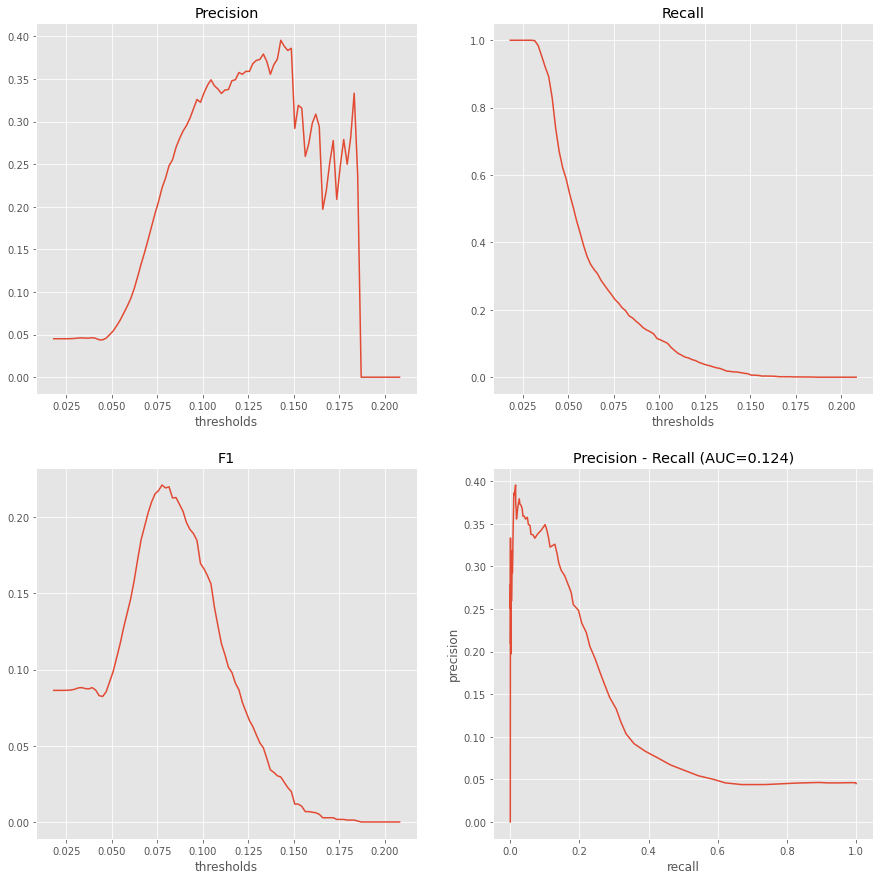

In [14]:
metrics.plot_precision_recall_f1_curve(
    cmodel.precision, cmodel.recall, cmodel.f1_score, cmodel.thresholds
)
